In [117]:
########################Import Modules##########################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import corner
import copy as duplicate
import time
from matplotlib import colors
import scipy as sp

from ipywidgets import IntProgress
from IPython.display import display

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

#####################################

# Generate One Source


In [118]:
def Template_Equation(x,y,theta):
    X,Y,A = theta
    R = 3                 # Keeping the spatil extent constant
    template = A*np.exp(-(((x-X)**2 + (y-Y)**2)/(2*R**2)))
    return template

In [119]:
npix = 50    # number of pixels
x = np.arange(0, npix, 1, float)
y = x[:,np.newaxis]


#Locations ,Spatial extent and Flux
X = 25
Y = 25
A = 15

theta_pic = np.array([X,Y,A])

#Gaussian Noise
noise_sigma = 1.0
Noise = np.random.normal(0,noise_sigma,(npix,npix))

# Image data
Img_data = Template_Equation(x,y,theta_pic) + Noise

Text(0,0.5,'Arbitrary Flux')

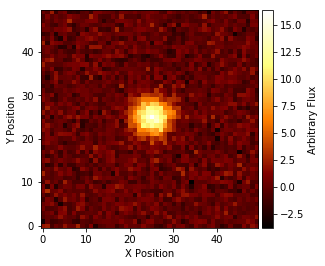

In [120]:
ax = plt.subplot(111)
im = ax.imshow(Img_data,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')

# Prior on [X,Y,A]

In [121]:
def LogPrior(theta,theta_limits):
    X,Y,A = theta
    Xlimits,Ylimits = theta_limits
    
    if (X < Xlimits[0]) | (X > Xlimits[1]):  #If position is out of limits discard 
        log_X_prior = -np.inf
    else:
        log_X_prior = np.log(1.0/(Xlimits[1] - Xlimits[0]))
        
    if (Y < Ylimits[0]) | (Y > Ylimits[1]):
        log_Y_prior = -np.inf
    else:
        log_Y_prior = np.log(1.0/(Ylimits[1] - Ylimits[0]))
    
    if (A<0):           # Positive flux
        log_A_prior = -np.inf
    else:
        log_A_prior = -A
    
    return log_X_prior + log_Y_prior + log_A_prior

# Likelihood

In [122]:
def LogL(theta,data,sigmay):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are

    Returns: scalar log likelihood
    '''
    y_data = data
    model = Template_Equation(x,y,theta)
    logL = (np.sum(np.log(1./(np.sqrt((2.*np.pi)*sigmay**2)))) +
            np.sum(-0.5 * (y_data - model)**2 / sigmay**2))
    return logL

# Generate walkers

In [123]:
def Get_particles_from_prior():   # Sampling from the prior space
    X = sp.stats.uniform.rvs(0,npix)
    Y = sp.stats.uniform.rvs(0,npix)
    A = sp.stats.uniform.rvs(5,20)
    theta = [X,Y,A]
    return theta

In [338]:
#Generate walkers

#Number of walkers
N = 80

particles = []
logp = np.empty(N)
logl = np.empty(N)

#Data and Noise 
data = Img_data
sigmay = Noise

#parameter limits
Xlimits = [0.0, npix]
Ylimits = [0.0,npix]
theta_limits = (Xlimits, Ylimits)

# Generate walkers
for i in range(0, N):
    theta = Get_particles_from_prior()
    particles.append(theta)              #Save each sample
    logl[i] = LogL(theta,data,sigmay)    # Save Likelihood of each sample
    logp[i] = LogPrior(theta,theta_limits)      #Save prior prob of each sample

# Initialize

In [339]:
# Number of NS iterations
nest_steps = 5000

# MCMC steps per NS iteration
mcmc_steps = 100

# mcmc stepsize
Xstep , Ystep , Astep = 0.02,0.03,0.04
stepsize = np.array([Xstep,Ystep,Astep])

#Number of parameters
num_params = 3



# Storage for results
keep = np.empty((nest_steps, num_params + 1))

nacceptance = np.zeros(nest_steps)
nrejectance = np.zeros(nest_steps)

# Main Nest

In [340]:
for i in range(nest_steps):
    
    worst = np.argmin(logl)   # Particle with worst likelihood
    
    keep[i,:-1] = particles[worst] # Save the details of the worst particle , (m,c) and (likelihood)
    keep[i,-1] = logl[worst]
    
    # Copy random survivor
    while True:#----copy a random point and do mcmc from there-----
        copy = np.random.randint(len(particles))
        if (copy != worst):break
            
    particles[worst] = duplicate.deepcopy(particles[copy]) # Throw away worst particle and replace with random particle 
                                                            #and do mcmc from the random particle (will change with new sample)
    
    logl_threshold = duplicate.deepcopy(logl[worst])    # Likelihood of worst point
    
    naccept = 0      #count number of accepted samples
    nreject = 0     #count number of rejected samples
    for mcmci in range(mcmc_steps):   # Do mcmc on the random survivor
        theta_new = particles[worst] + stepsize * np.random.randn(len(theta))  #Generate new sample
        logl_new = LogL(theta_new,data,sigmay)                                 #Likelihood of new sample
        
        logp_new = LogPrior(theta_new,theta_limits)                           #prior prob of new sample
        
        if (logl_new>logl_threshold) and (logp_new-logp[worst])>=np.log(np.random.rand()): #Accept new sample
            particles[worst] = theta_new                                #replace worst sample with new sample
            logp[worst] = logp_new                                      # replace worstp with newp of new sample
            logl[worst] = logl_new                                      #replace worstL with newL of new sample
            
            naccept += 1                                              #increment number of accepted sample 
            
        else: # otherwise reject new sample 
            particles[worst] = particles[worst]     #stay at current position and look for new sample again
            nreject += 1
    
    nacceptance[i] = naccept/mcmc_steps #evaluate mcmc acceptance ratio



#Prior Mass    
logX = -(np.arange(0, (nest_steps))+ 1.)/N  # evalute prior mass

Text(0,0.5,'Acceptance Ratio')

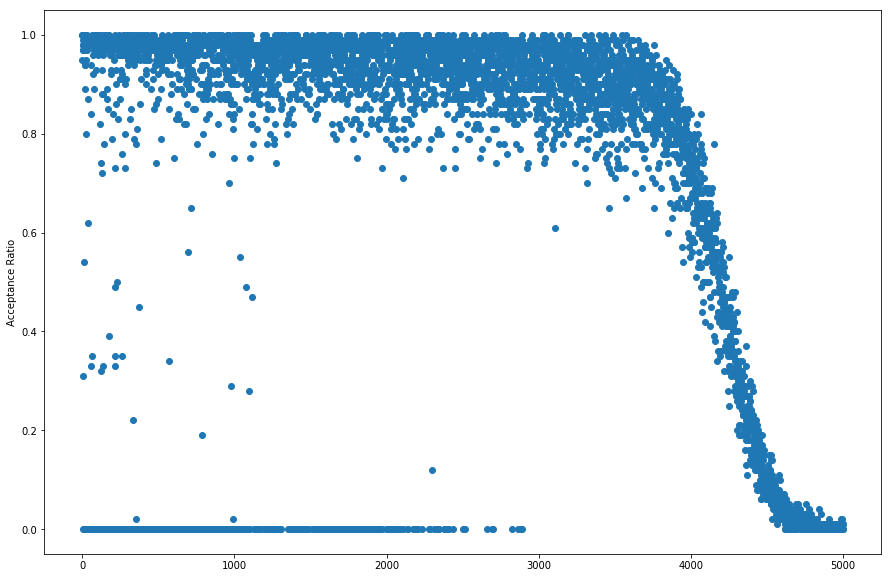

In [341]:
plt.figure(figsize=(15,10))
plt.plot(nacceptance,'o')
plt.ylabel('Acceptance Ratio')

Text(0.5,0,'$\\log(X)$')

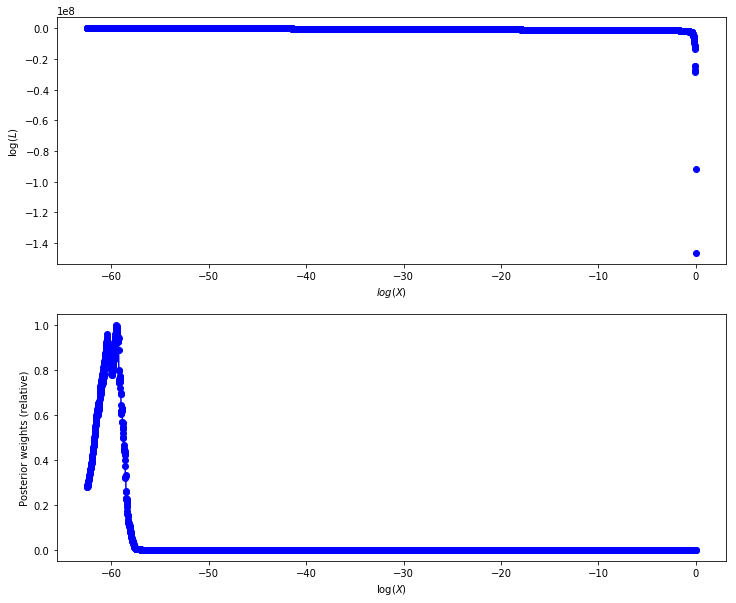

In [342]:
#Visualize Likelihood vs Prior Mass

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(logX, keep[0:(nest_steps), -1], 'bo')
plt.ylabel('$\\log(L)$')
plt.xlabel('$log(X)$')



plt.subplot(2,1,2)

#Posterior weights

logwt = logX.copy() + keep[0:(nest_steps), -1]

wt = np.exp(logwt - logwt.max())              # Normalised posterior weights
plt.plot(logX, wt, 'bo-')
plt.ylabel('Posterior weights (relative)')
plt.xlabel('$\\log(X)$')

In [331]:
# Useful function #Compute the log of the sum of exponentials of input elements.
# OR from scipy.misc import logsumexp 

def logsumexp(values):
    biggest = np.max(values)
    x = values - biggest
    result = np.log(np.sum(np.exp(x))) + biggest
    return result



# Prior weights
logw = logX.copy()
# Normalise them
logw -= logsumexp(logw)  

# Calculate marginal likelihood
logZ = logsumexp(logw + keep[:,-1])

# Normalised posterior weights
wt = wt/wt.sum()

effective_sample_size = int(np.exp(-np.sum(wt*np.log(wt + 1E-300))))

# Calculate information
H = np.sum(wt*(keep[:,-1] - logZ))

print('logZ = {logZ} '.format(logZ=logZ))
print('Information = {H}'.format(H=H))
print('Effective Sample Size = {ess}'.format(ess=effective_sample_size))

logZ = -1970.5892724513926 
Information = 25.122282789164665
Effective Sample Size = 281


# Compute the weighted Posterior results

In [332]:
posterior_samples = np.empty((effective_sample_size, keep.shape[1]))
logX_effective = np.empty(effective_sample_size)
k = 0
while True:
  # Choose one of the samples
    which = np.random.randint(keep.shape[0])

  # Acceptance probability
    prob = wt[which]/wt.max()

    if np.random.rand() <= prob:
        posterior_samples[k, :] = keep[which, :]
        logX_effective[k] = logX[k]
        k += 1

    if k >= effective_sample_size:
        break

np.savetxt('keep_Many.txt', posterior_samples)

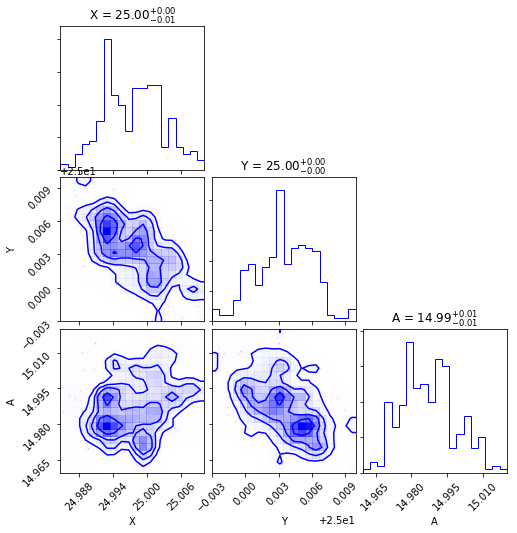

In [333]:
Fig = corner.corner(posterior_samples[:,:-1], labels=['X','Y','A'],show_titles=True,color='b',smooth=1.0);

Text(0,0.5,'Arbitrary Flux')

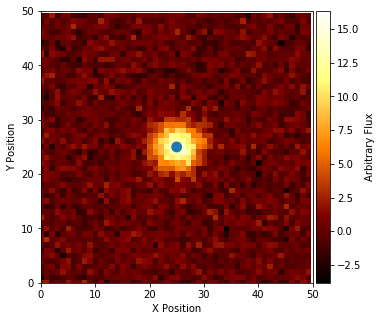

In [334]:
plt.figure(figsize=(7,5))
ax = plt.gca()
ellipses = []
plt.xlim([0,npix])
plt.ylim([0,npix])
X_pos = [24.99]
Y_pos = [24.99]
for ra, dec in zip(X_pos,Y_pos):
    ellipse = Ellipse(xy=(ra, dec), width=2, height=2, angle=0)
    ellipses.append(ellipse)

p = PatchCollection(ellipses)
ax.add_collection(p)

im = ax.imshow(Img_data,origin='lower',cmap='afmhot',)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.ylabel('Arbitrary Flux')

In [335]:

#Number of Zs
nZ = 1000
logZs = np.zeros(nZ+1)

for s in range(nZ):
    u = -1*np.random.uniform(0,1,nest_steps)
    logXs = np.zeros(len(u))
    Value = 1

    for i in range(len(u)):
        Value *= u[i]
        logXs[i] = Value
    
    logXs[-1] = 1
    logXs[0] = 0
    # Prior weights
    logws = logXs.copy()
    # Normalise them
    logws -= logsumexp(logws)  

    # Calculate marginal likelihood
    logZs[s] = logsumexp(logws + keep[:,-1])

logZs[-1] = logZ

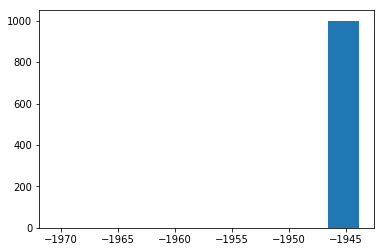

In [336]:
plt.hist(logZs);

In [337]:
np.mean(logZs),np.std(logZs)

(-1943.8869926244342, 0.844400231860083)